In [1]:
#Setting the needed imports and path
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
DATA_PATH = Path("../data/Motor_Vehicle_Collisions_-_Crashes.csv")
OUT_DIR = Path("../data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def column_inventory(df, top_n=8):
    n = len(df)
    rows = []
    for col in df.columns:
        ser = df[col]
        nn = int(ser.notna().sum())
        null_rate = 1 - nn / n
        nunique = int(ser.nunique(dropna=True))
        top_vals = ser.dropna().value_counts().nlargest(top_n).to_dict()
        rows.append({
            "column": col,
            "dtype": str(ser.dtype),
            "n_nonnull": nn,
            "null_rate": round(float(null_rate), 4),
            "nunique": nunique,
            "top_vals_sample": top_vals
        })
    return pd.DataFrame(rows).sort_values("null_rate", ascending=False)

sample = pd.read_csv(DATA_PATH, nrows=5000, low_memory=False)
inv_df = column_inventory(sample)
inv_df.head(50) 
inv_df.to_csv(OUT_DIR / "column_inventory_sample.csv", index=False)
print("Inventory saved to:", OUT_DIR / "column_inventory_sample.csv")


Inventory saved to: ..\data\processed\column_inventory_sample.csv


In [3]:
#The cols we're interested in
KEEP_COLS = [
    "CRASH DATE", "CRASH TIME",
    "BOROUGH", "ZIP CODE", "LATITUDE", "LONGITUDE", "LOCATION",
    "ON STREET NAME", "CROSS STREET NAME", "OFF STREET NAME",
    "NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED",
    "NUMBER OF PEDESTRIANS INJURED", "NUMBER OF PEDESTRIANS KILLED",
    "NUMBER OF CYCLIST INJURED", "NUMBER OF CYCLIST KILLED",
    "NUMBER OF MOTORIST INJURED", "NUMBER OF MOTORIST KILLED",
    "CONTRIBUTING FACTOR VEHICLE 1",
    "VEHICLE TYPE CODE 1",
    "COLLISION_ID"
]

sample_cols = pd.read_csv(DATA_PATH, nrows=2).columns.tolist()
KEEP_COLS = [c for c in KEEP_COLS if c in sample_cols]
print("Final keep columns ({}):".format(len(KEEP_COLS)))
for c in KEEP_COLS:
    print(" -", c)

Final keep columns (21):
 - CRASH DATE
 - CRASH TIME
 - BOROUGH
 - ZIP CODE
 - LATITUDE
 - LONGITUDE
 - LOCATION
 - ON STREET NAME
 - CROSS STREET NAME
 - OFF STREET NAME
 - NUMBER OF PERSONS INJURED
 - NUMBER OF PERSONS KILLED
 - NUMBER OF PEDESTRIANS INJURED
 - NUMBER OF PEDESTRIANS KILLED
 - NUMBER OF CYCLIST INJURED
 - NUMBER OF CYCLIST KILLED
 - NUMBER OF MOTORIST INJURED
 - NUMBER OF MOTORIST KILLED
 - CONTRIBUTING FACTOR VEHICLE 1
 - VEHICLE TYPE CODE 1
 - COLLISION_ID


In [4]:
df = pd.read_csv(DATA_PATH, usecols=KEEP_COLS, low_memory=False)
print("Loaded df shape:", df.shape)
df.head()

Loaded df shape: (2196754, 21)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,0.0,0,0,0,0,2,0,Aggressive Driving/Road Rage,4455765,Sedan
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,0.0,0,0,0,0,1,0,Pavement Slippery,4513547,Sedan
2,11/01/2023,1:29,BROOKLYN,11230,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,0.0,0,0,0,0,1,0,Unspecified,4675373,Moped
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,0.0,0,0,0,0,0,0,Following Too Closely,4541903,Sedan
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,0.0,0,0,0,0,0,0,Passing Too Closely,4566131,Station Wagon/Sport Utility Vehicle


In [5]:
#Cleaning the data

df.columns = [c.strip() for c in df.columns]

# ZIP CODE to string  
if "ZIP CODE" in df.columns:
    df["ZIP CODE"] = df["ZIP CODE"].astype(str).str.strip().replace({'nan': None, 'None': None})

# Ensuring numeric injury/killed columns are numeric 
num_cols = [c for c in df.columns if ("NUMBER OF" in c) or ("KILLED" in c) or ("INJURED" in c)]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

print("Numeric columns cleaned:", num_cols)
df[num_cols].describe().T

Numeric columns cleaned: ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']


,count,mean,std,min,25%,50%,75%,max
NUMBER OF PERSONS INJURED,2196754.0,0.325197,0.712431,0.0,0.0,0.0,0.0,43.0
NUMBER OF PERSONS KILLED,2196754.0,0.001568,0.041786,0.0,0.0,0.0,0.0,8.0
NUMBER OF PEDESTRIANS INJURED,2196754.0,0.059121,0.249121,0.0,0.0,0.0,0.0,27.0
NUMBER OF PEDESTRIANS KILLED,2196754.0,0.000777,0.028487,0.0,0.0,0.0,0.0,6.0
NUMBER OF CYCLIST INJURED,2196754.0,0.028657,0.169037,0.0,0.0,0.0,0.0,4.0
NUMBER OF CYCLIST KILLED,2196754.0,0.000123,0.011147,0.0,0.0,0.0,0.0,2.0
NUMBER OF MOTORIST INJURED,2196754.0,0.232927,0.673614,0.0,0.0,0.0,0.0,43.0
NUMBER OF MOTORIST KILLED,2196754.0,0.000639,0.027598,0.0,0.0,0.0,0.0,5.0


In [6]:
# CRASH DATE is MM/DD/YYYY in this dataset (US). Time is mostly 'H:MM' or 'HH:MM'.
# Vectorized time normalization:
time_raw = df["CRASH TIME"].astype(str).str.strip().fillna("")
time_raw = time_raw.replace({"nan": "", "NaN": "", "None": ""})

# Extract hh:mm where present
hhmm = time_raw.str.extract(r'(?P<hhmm>\d{1,2}:\d{2})')['hhmm']

mask_no_colon = hhmm.isna()
digits = time_raw[mask_no_colon].str.extract(r'(\d{1,4})')[0].fillna('')
digits_padded = digits.str.zfill(4)
formatted = digits_padded.str.slice(0,2) + ':' + digits_padded.str.slice(2,4)
hhmm.loc[mask_no_colon] = formatted.values
df["time_norm"] = hhmm.fillna('').astype(str)

# Parse date explicitly as MM/DD/YYYY
df["date_parsed"] = pd.to_datetime(df["CRASH DATE"], format="%m/%d/%Y", errors="coerce")

# Combine date + normalized time
combined = df["date_parsed"].dt.strftime("%Y-%m-%d").fillna('') + ' ' + df["time_norm"].fillna('')
combined = combined.str.strip()
df["ts"] = pd.to_datetime(combined, errors="coerce", infer_datetime_format=True)

# Report success rate
total = len(df)
parsed = df["ts"].notna().sum()
print(f"Total rows: {total:,}")
print(f"Parsed ts: {parsed:,}  ({parsed/total:.2%})")

Total rows: 2,196,754
Parsed ts: 2,196,754  (100.00%)


In [7]:
mask_date_present_but_no_ts = df["CRASH DATE"].notna() & df["ts"].isna()
print("Rows where CRASH DATE present but ts failed:", mask_date_present_but_no_ts.sum())

# Show a small sample of problematic pairs to see patterns
display(df.loc[mask_date_present_but_no_ts, ["CRASH DATE", "CRASH TIME"]].drop_duplicates().head(40))

# Rows with no CRASH DATE (rare?) — they cannot be used for time analysis
print("Rows missing CRASH DATE entirely:", df["CRASH DATE"].isna().sum())

Rows where CRASH DATE present but ts failed: 0


,CRASH DATE,CRASH TIME


Rows missing CRASH DATE entirely: 0


In [8]:
# Keeping only rows with ts for time based analysis
df_time = df[df["ts"].notna()].copy()
df_time["hour"] = df_time["ts"].dt.hour
df_time["weekday"] = df_time["ts"].dt.dayofweek   
df_time["is_weekend"] = df_time["weekday"].isin([5,6]).astype(int)
df_time["date"] = df_time["ts"].dt.date

df_time["severe"] = (
    (df_time["NUMBER OF PERSONS INJURED"] > 0) |
    (df_time["NUMBER OF PERSONS KILLED"] > 0)
).astype(int)

print("df_time rows:", len(df_time))
df_time[["ts","hour","weekday","severe"]].head()

df_time rows: 2196754


,ts,hour,weekday,severe
0,2021-09-11 02:39:00,2,5,1
1,2022-03-26 11:45:00,11,5,1
2,2023-11-01 01:29:00,1,2,1
3,2022-06-29 06:55:00,6,2,0
4,2022-09-21 13:21:00,13,2,0


In [9]:
df_geo = df_time.dropna(subset=["LATITUDE", "LONGITUDE"]).copy()

zero_coords_mask = (df_geo["LATITUDE"] == 0) | (df_geo["LONGITUDE"] == 0)
print("Rows with LAT or LON exactly 0:", zero_coords_mask.sum())

lat_min, lat_max = 40.4774, 40.9176
lon_min, lon_max = -74.2591, -73.7004

mask_valid_nyc = (
    df_geo["LATITUDE"].between(lat_min, lat_max) &
    df_geo["LONGITUDE"].between(lon_min, lon_max)
)
df_geo_clean = df_geo[mask_valid_nyc].copy()
print("Rows with geo coords before filter:", len(df_geo))
print("Rows inside NYC bounding box:", len(df_geo_clean))
print("Rows removed:", len(df_geo) - len(df_geo_clean))

PRECISION = 4   
df_geo_clean["lat_round"] = df_geo_clean["LATITUDE"].round(PRECISION)
df_geo_clean["lon_round"] = df_geo_clean["LONGITUDE"].round(PRECISION)
df_geo_clean["segment_id"] = df_geo_clean["lat_round"].astype(str) + "_" + df_geo_clean["lon_round"].astype(str)

print("Unique segments (approx):", df_geo_clean["segment_id"].nunique())
df_geo_clean[["LATITUDE","LONGITUDE","segment_id"]].head()


Rows with LAT or LON exactly 0: 5944
Rows with geo coords before filter: 1956597
Rows inside NYC bounding box: 1950503
Rows removed: 6094
Unique segments (approx): 224155


,LATITUDE,LONGITUDE,segment_id
2,40.621790,-73.970024,40.6218_-73.97
9,40.667202,-73.866500,40.6672_-73.8665
10,40.683304,-73.917274,40.6833_-73.9173
12,40.709183,-73.956825,40.7092_-73.9568
13,40.868160,-73.831480,40.8682_-73.8315


In [10]:
#Sorting by day, hour and week + day
daily = df_time.set_index("ts").resample("D").size().rename("crash_count").reset_index()

hourly = df_time.groupby("hour").size().reindex(range(24), fill_value=0)

pivot = df_time.pivot_table(index="weekday", columns="hour", values="ts", aggfunc="count").fillna(0)

# Useing cleaned data to compute top segments 
top_segments = df_geo_clean["segment_id"].value_counts().nlargest(20)

print("Daily rows:", len(daily))
print("Hourly counts sum (sanity):", hourly.sum())
print("Top segments (cleaned):")
display(top_segments.head(20))

Daily rows: 4784
Hourly counts sum (sanity): 2196754
Top segments (cleaned):


segment_id
40.696_-73.9845     1399
40.6757_-73.8969    1016
40.6586_-73.8906     974
40.7606_-73.9643     947
40.8619_-73.9128     913
40.7335_-73.8704     864
40.6782_-73.8975     845
40.6685_-73.9256     812
40.6088_-74.0381     809
40.838_-73.8733      766
40.7203_-73.994      748
40.68_-73.8774       735
40.7572_-73.9898     710
40.7045_-73.8174     698
40.759_-73.9959      675
40.7616_-73.9666     674
40.7832_-73.9447     672
40.7241_-73.9926     671
40.8028_-73.9336     668
40.6762_-73.9081     660
Name: count, dtype: int64

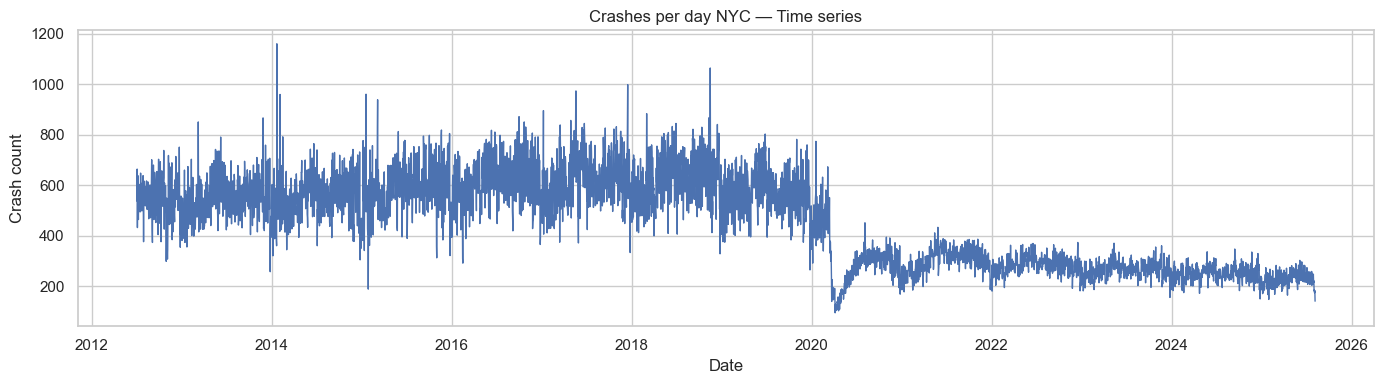

In [11]:
#Plot for crashes per day

plt.figure(figsize=(14,4))
plt.plot(daily["ts"], daily["crash_count"], linewidth=1)
plt.title("Crashes per day NYC — Time series")
plt.xlabel("Date")
plt.ylabel("Crash count")
plt.tight_layout()
plt.show()

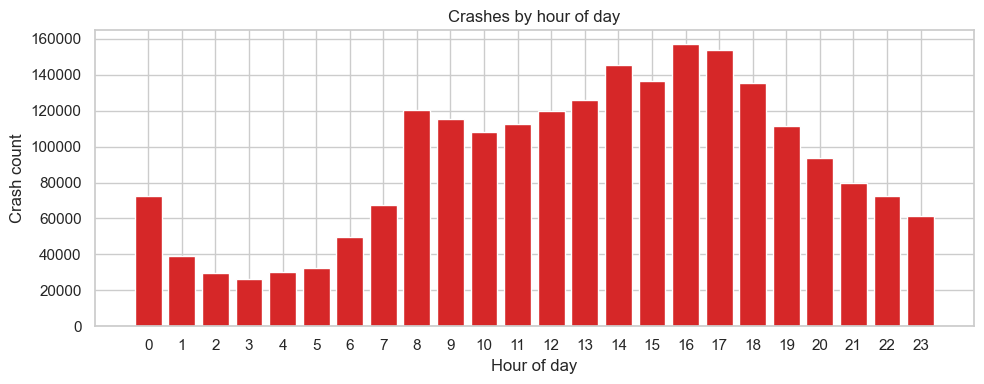

In [12]:
#Plot for crashes per hour

hourly = df_time.groupby("hour").size().reindex(range(24), fill_value=0)

plt.figure(figsize=(10,4))
plt.bar(hourly.index, hourly.values, color='tab:red')
plt.xticks(range(24))
plt.xlabel("Hour of day")
plt.ylabel("Crash count")
plt.title("Crashes by hour of day")
plt.tight_layout()
plt.show()


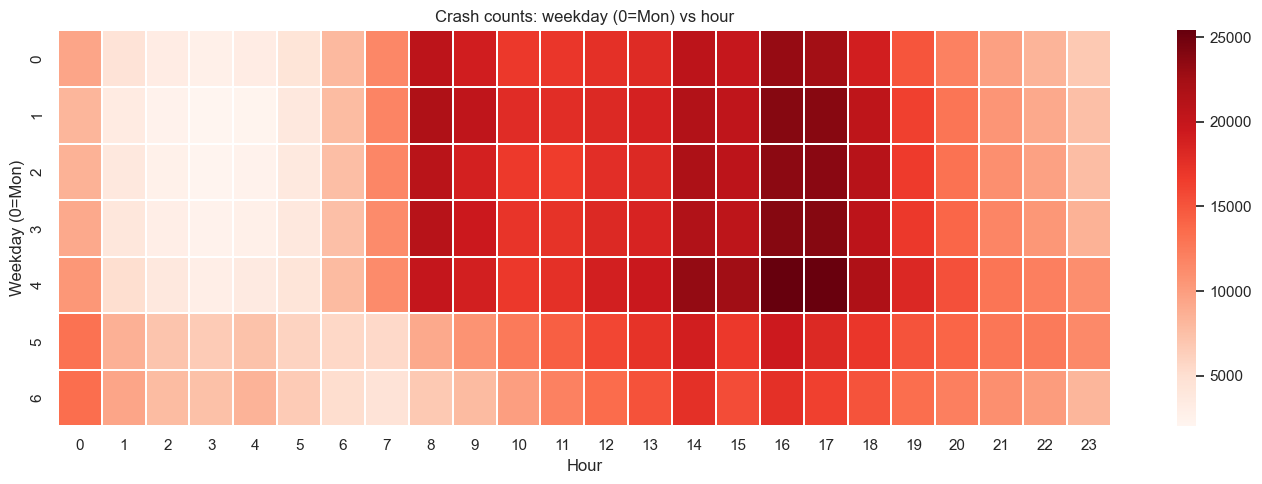

In [13]:
#Week x hour heatmap

plt.figure(figsize=(14,5))
sns.heatmap(pivot, cmap="Reds", linewidths=0.2)
plt.title("Crash counts: weekday (0=Mon) vs hour")
plt.xlabel("Hour")
plt.ylabel("Weekday (0=Mon)")
plt.tight_layout()
plt.show()

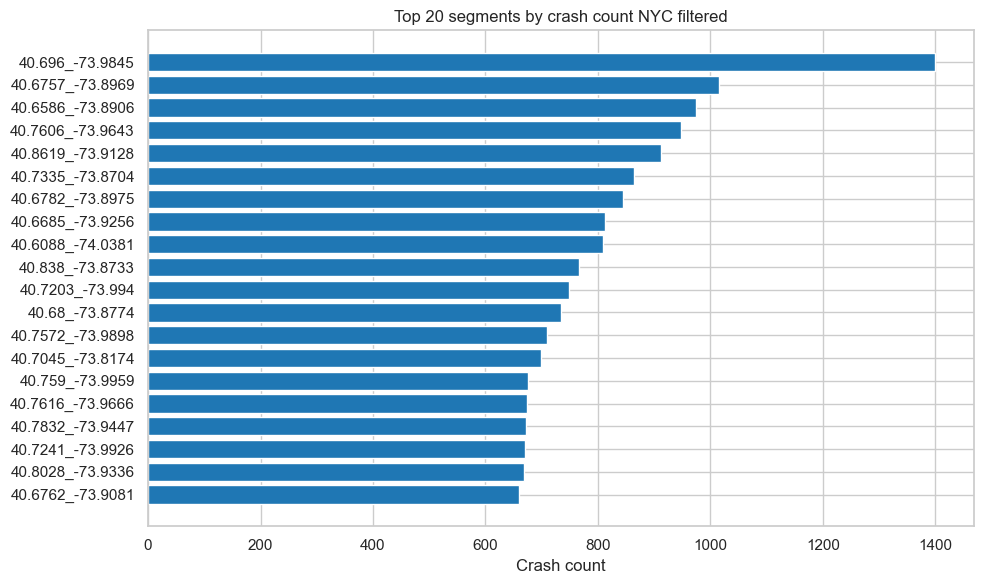

In [14]:
#Top segments

top_segments = df_geo_clean["segment_id"].value_counts().nlargest(20)

fig, ax = plt.subplots(figsize=(10,6))
y = range(len(top_segments))
ax.barh(y, top_segments.values[::-1], color='tab:blue') 
ax.set_yticks(y)
ax.set_yticklabels(top_segments.index[::-1])
ax.set_xlabel("Crash count")
ax.set_title("Top 20 segments by crash count NYC filtered")
plt.tight_layout()
plt.show()

In [15]:
#Saving the cleaned data

df_small = df_time.copy()

if "COLLISION_ID" in df_small.columns and "COLLISION_ID" in df_geo_clean.columns:
    df_small = df_small.merge(
        df_geo_clean[["COLLISION_ID", "segment_id"]],
        how="left",
        on="COLLISION_ID"
    )

cols_to_save = [
    "ts","date","hour","weekday","is_weekend","severe",
    "LATITUDE","LONGITUDE","segment_id",
    "BOROUGH","ZIP CODE","ON STREET NAME","CROSS STREET NAME","COLLISION_ID"
]
cols_to_save = [c for c in cols_to_save if c in df_small.columns]

out_file = OUT_DIR / "vehicle_collisions_subset.parquet"

try:
    df_small[cols_to_save].to_parquet(out_file, index=False)
    print("Saved cleaned subset to:", out_file)
except Exception as e:
    print("Failed to write parquet. If the error mentions 'pyarrow' or 'fastparquet',")
    print("install pyarrow in your active conda env and re-run this cell:")
    print("  conda install -c conda-forge pyarrow -y")
    print("\nFull error below:\n")
    raise


Saved cleaned subset to: ..\data\processed\vehicle_collisions_subset.parquet
